In [12]:
import math
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import hcpdatautils as hcp

In [13]:
bool_type = torch.bool
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

In [14]:
data_dir = 'E:\\HCP_data'
results_dir = 'E:\\Ising_model_results_daai'

In [6]:
data_subset = 'validation'
data_ts_file = os.path.join(results_dir, f'data_ts_gt_median_{data_subset}.pt')
data_ts = torch.load(data_ts_file)
print( 'data_ts size', data_ts.size() )
unique_states_file = os.path.join(results_dir, f'unique_states__{data_subset}.pt')
unique_states = torch.load(unique_states_file)
print( 'unique_states size', unique_states.size() )
unique_state_counts_file = os.path.join(results_dir, f'unique_state_counts__{data_subset}.pt')
unique_state_counts = torch.load(unique_state_counts_file)
print( 'unique_state_counts size', unique_state_counts.size() )
state_transition_counts_file = os.path.join(results_dir, f'state_transition_counts__{data_subset}.pt')
state_transition_counts = torch.load(state_transition_counts_file)
print( 'state_transition_counts size', state_transition_counts.size() )
flip_number_counts_file = os.path.join(results_dir, f'flip_number_counts__{data_subset}.pt')
flip_number_counts = torch.load(flip_number_counts_file)
print( 'flip_number_counts size', flip_number_counts.size() )

data_ts size torch.Size([84, 4, 360, 1200])
unique_states size torch.Size([400575, 360])
unique_state_counts size torch.Size([400575])
state_transition_counts size torch.Size([400575, 360])
flip_number_counts size torch.Size([361])


In [15]:
def make_histogram(name:str, values:torch.Tensor):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    axs.hist( values.flatten().detach().cpu().numpy() )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(name)
    axs.set_ylabel('count in bin')
    axs.set_title(f'distribution of {name}')
    plt.show()

In [16]:
def print_stats(name:str, values:torch.Tensor):
    values = values.flatten()
    quantile_cutoffs = torch.tensor([0.025, 0.5, 0.975], dtype=float_type, device=device)
    quantiles = torch.quantile(values, quantile_cutoffs)
    min_val = torch.min(values)
    max_val = torch.max(values)
    print(f'The distribution of {name} has median {quantiles[1].item():.3g} with 95% CI [{quantiles[0].item():.3g}, {quantiles[2].item():.3g}] and range [{min_val.item():.3g}, {max_val.item():.3g}].')

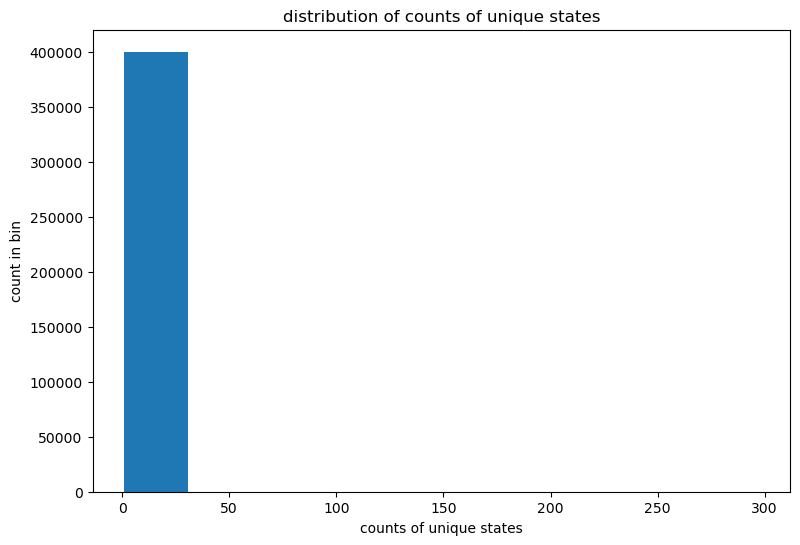

The distribution of counts of unique states has median 1 with 95% CI [1, 1] and range [1, 297].


In [11]:
make_histogram(name='counts of unique states', values=unique_state_counts)
print_stats( name='counts of unique states', values=unique_state_counts.float() )

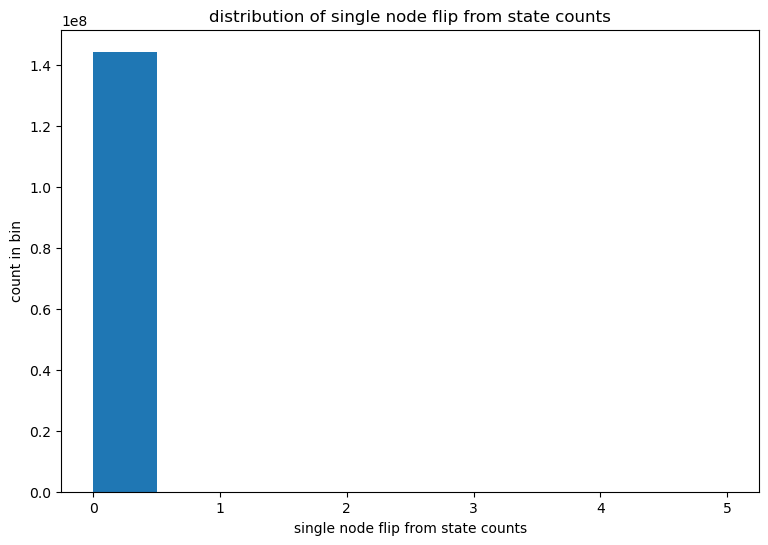

RuntimeError: quantile() input tensor is too large

In [12]:
make_histogram(name='single node flip from state counts', values=state_transition_counts)
# print_stats( name='single node flip from state counts', values=state_transition_counts.float() )

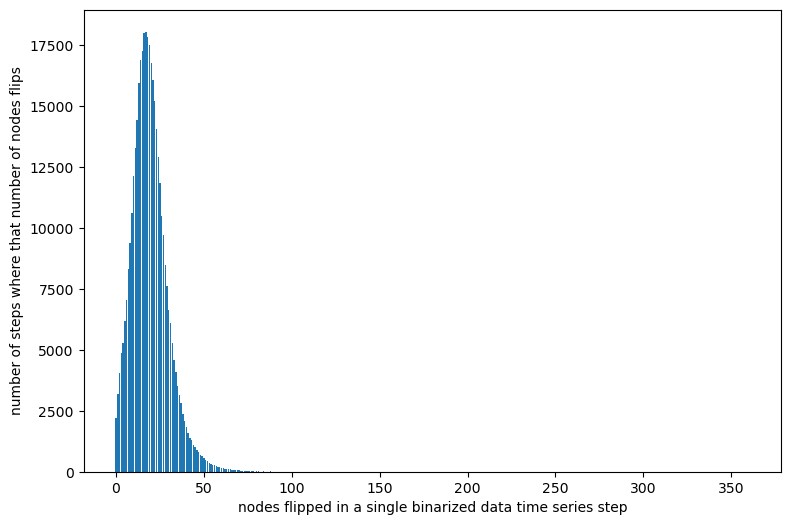

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.bar(  x=range( flip_number_counts.numel() ), height=flip_number_counts.tolist()  )
axs.set_xlabel('nodes flipped in a single binarized data time series step')
axs.set_ylabel('number of steps where that number of nodes flips')
# axs.set_title(f'Ising model mean time series with same parameters and different beta')
plt.show()

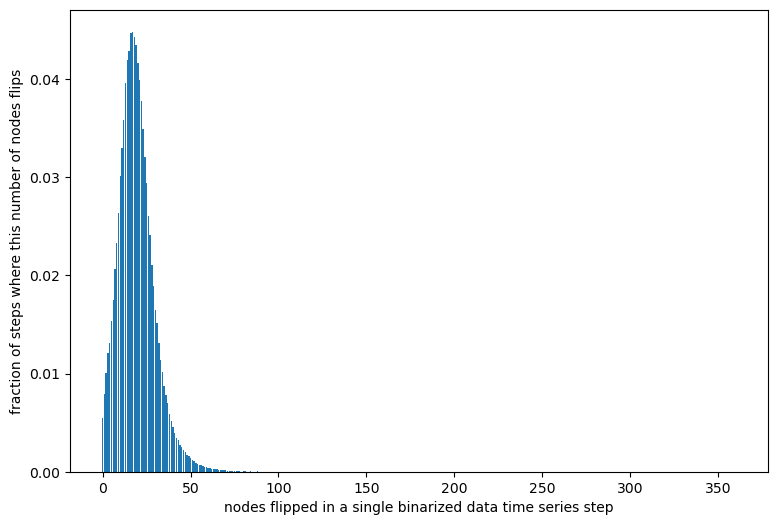

In [25]:
flip_freq = flip_number_counts/flip_number_counts.sum()
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.bar(  x=range( flip_number_counts.numel() ), height=flip_freq.tolist()  )
axs.set_xlabel('nodes flipped in a single binarized data time series step')
axs.set_ylabel('fraction of steps where this number of nodes flips')
# axs.set_title(f'Ising model mean time series with same parameters and different beta')
plt.show()

In [26]:
max_flips = 4
num_transitions_with_le_max_flips = flip_number_counts[:max_flips+1].sum()
num_transitions = flip_number_counts.sum()
fraction_with_le_max_flips = num_transitions_with_le_max_flips/num_transitions
print(f'{num_transitions_with_le_max_flips} out of {num_transitions} transitions ({fraction_with_le_max_flips:.3g}) have {max_flips} or fewer flips.')

19577 out of 402864 transitions (0.0486) have 4 or fewer flips.


In [27]:
most_common_num_flipped = torch.argmax(flip_freq)
max_flip_freq = flip_freq[most_common_num_flipped]
print(f'The most common number of nodes flipped is {most_common_num_flipped} with frequency {max_flip_freq:.3g}.')

The most common number of nodes flipped is 17 with frequency 0.0448.


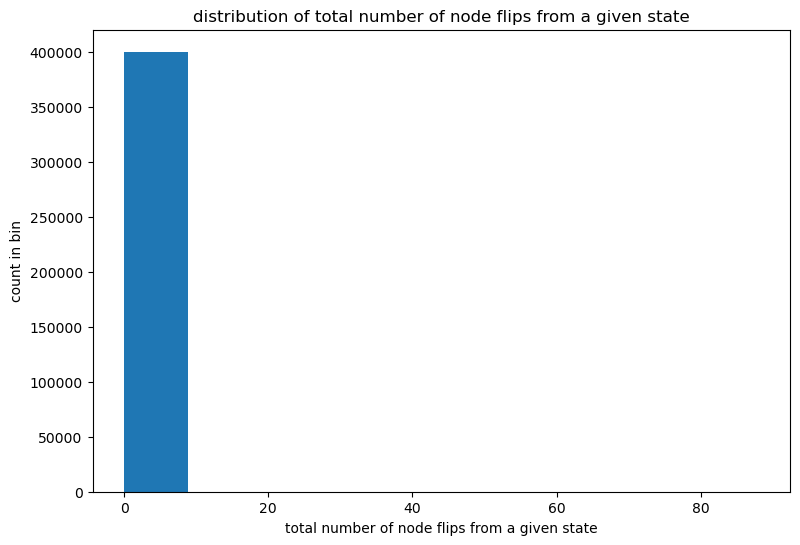

The distribution of total number of node flips from a given state has median 1 with 95% CI [1, 1] and range [0, 88].


In [29]:
total_flips_from_state = torch.sum(state_transition_counts, dim=1)
name = 'total number of node flips from a given state'
make_histogram(name=name, values=total_flips_from_state)
print_stats( name=name, values=total_flips_from_state.float() )

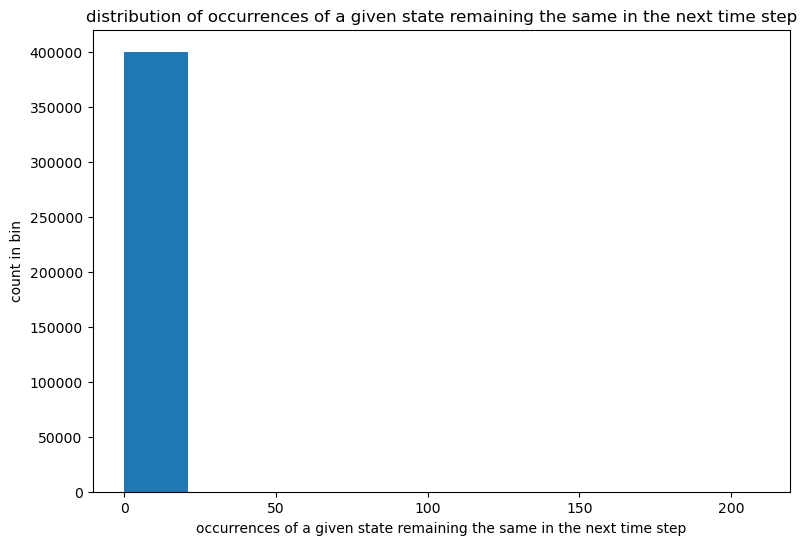

The distribution of occurrences of a given state remaining the same in the next time step has median 0 with 95% CI [-1.19e-07, 5.96e-08] and range [-2.38e-07, 209].


In [30]:
non_flip_counts = unique_state_counts - total_flips_from_state
name = 'occurrences of a given state remaining the same in the next time step'
make_histogram(name=name, values=non_flip_counts)
print_stats( name=name, values=non_flip_counts.float() )

In [43]:
epsilon = 10e-10
prob_flip = state_transition_counts / unique_state_counts.unsqueeze(dim=1)
prob_no_flip = non_flip_counts.clamp_min(0) / unique_state_counts
transition_entropy = -torch.sum( prob_flip * (prob_flip + epsilon).log2(), dim=1 ) - prob_no_flip * (prob_no_flip + epsilon).log2()
print( transition_entropy.size() )

torch.Size([400575])


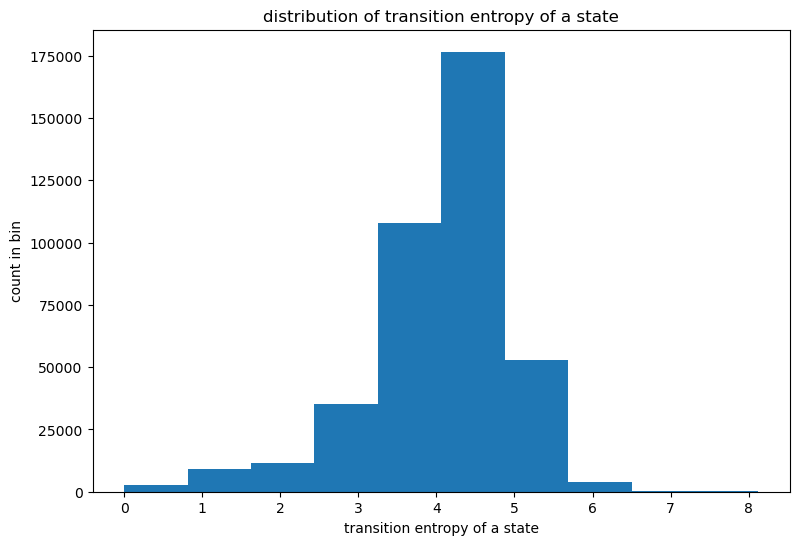

The distribution of transition entropy of a state has median 4.17 with 95% CI [1.58, 5.46] and range [0, 8.12].


In [44]:
name = 'transition entropy of a state'
make_histogram(name=name, values=transition_entropy)
print_stats( name=name, values=transition_entropy.float() )

In [46]:
num_choices = 361
p_even = 1/361
entropy_even = -math.log2(p_even)# * p_even * num_choices
print(entropy_even)

8.49585502688717


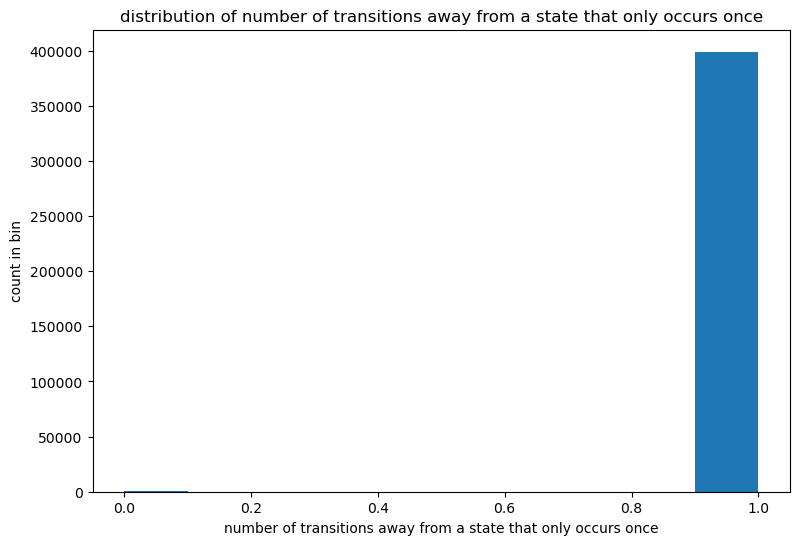

The distribution of number of transitions away from a state that only occurs once has median 1 with 95% CI [1, 1] and range [0, 1].


In [47]:
total_flips_from_state_singletons = total_flips_from_state[unique_state_counts == 1]
name = 'number of transitions away from a state that only occurs once'
make_histogram(name=name, values=total_flips_from_state_singletons)
print_stats( name=name, values=total_flips_from_state_singletons.float() )

In [53]:
print( torch.count_nonzero(total_flips_from_state_singletons == 1.0).item(), 'have 1 transition away' )
print( torch.count_nonzero(total_flips_from_state_singletons == 0.0).item(), 'have 0 transitions away' )
print( total_flips_from_state_singletons.numel(), 'states occur once in total' )

373320 have 1 transition away
336 have 0 transitions away
399330 states occur once in total


In [55]:
has_weird_number_of_transitions_from_singletons = torch.logical_and( (total_flips_from_state_singletons != 1.0), (total_flips_from_state_singletons != 0.0) )
print( torch.count_nonzero(has_weird_number_of_transitions_from_singletons).item(), 'singleton states have a number of transitions away that is neither 0 nor 1.' )
weird_transition_numbers_from_singletons = total_flips_from_state_singletons[has_weird_number_of_transitions_from_singletons]
print(f'These range from {weird_transition_numbers_from_singletons.min()} to {weird_transition_numbers_from_singletons.max()}.')

25674 singleton states have a number of transitions away that is neither 0 nor 1.
These range from 0.9999998807907104 to 1.000000238418579.


In [19]:
fc_correlation_file = os.path.join(results_dir, f'fc_correlation_group_training_parallel_10000_beta_sims_3_fitting_sims_30_steps_120000_learning_rate_0.1.pt')
fc_correlation = torch.load(fc_correlation_file)
print( 'fc_correlation size', fc_correlation.size() )

fc_correlation size torch.Size([10000])


In [20]:
fc_rmse_file = os.path.join(results_dir, f'fc_rmse_group_training_parallel_10000_beta_sims_3_fitting_sims_30_steps_120000_learning_rate_0.1.pt')
fc_rmse = torch.load(fc_rmse_file)
print( 'fc_rmse size', fc_rmse.size() )

fc_rmse size torch.Size([10000])


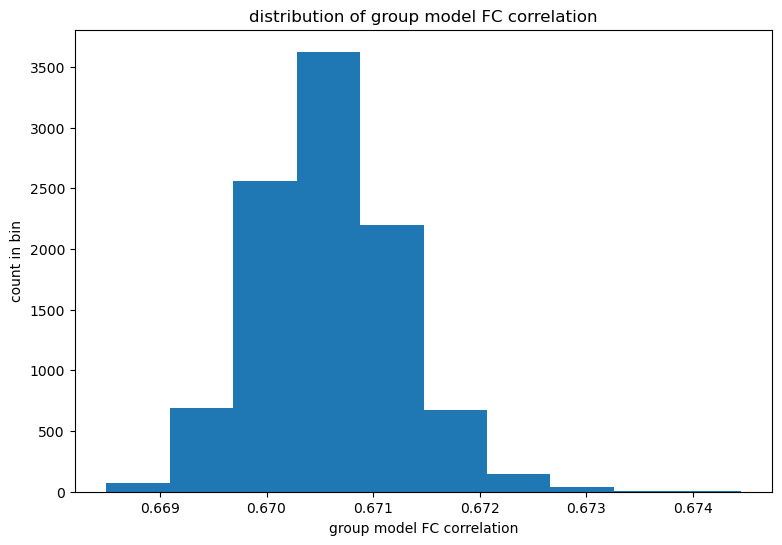

The distribution of group model FC correlation has median 0.671 with 95% CI [0.669, 0.672] and range [0.668, 0.674].


In [21]:
name = 'group model FC correlation'
make_histogram(name=name, values=fc_correlation)
print_stats( name=name, values=fc_correlation.float() )

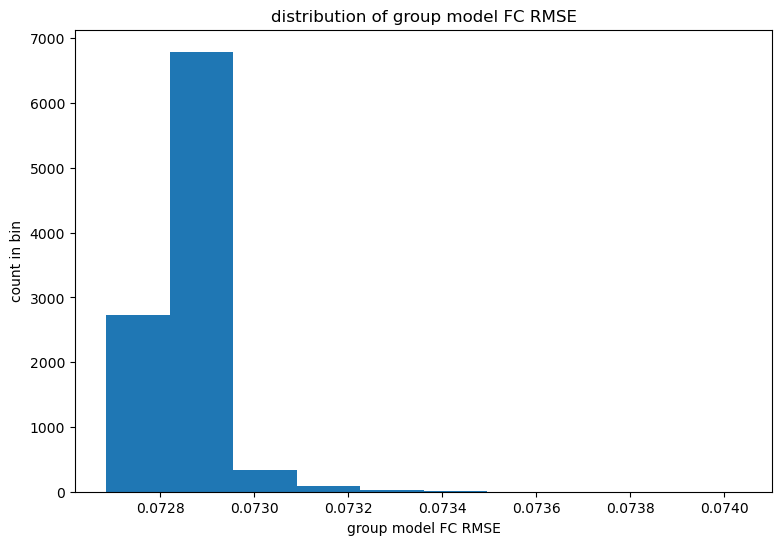

The distribution of group model FC RMSE has median 0.0728 with 95% CI [0.0728, 0.073] and range [0.0727, 0.074].


In [23]:
name = 'group model FC RMSE'
make_histogram(name=name, values=fc_rmse)
print_stats( name=name, values=fc_rmse.float() )

In [62]:
# If a flip occurs with probability < 1/num_nodes, that suggests that it is energetically unfavorable.
num_states, num_nodes = prob_flip.size()
print( num_states, num_nodes)
total_num_flips = num_states * num_nodes
flip_is_unobserved = prob_flip <= 0
num_unobserved = torch.count_nonzero(flip_is_unobserved)
print(f'{num_unobserved} out of {total_num_flips} flips from observed starting states, {num_unobserved/total_num_flips:.3g}, do not occur in the data.')
flip_is_unfavored = prob_flip < 1/num_nodes
num_unfavored = torch.count_nonzero(flip_is_unfavored)
print(f'{num_unfavored} out of {total_num_flips} flips from observed starting states, {num_unfavored/total_num_flips:.3g}, have probability less than 1/N, suggesting that, in the Ising model, they should be energetically unfavorable.')
flip_is_favored = prob_flip >= 1/num_nodes
num_favored = torch.count_nonzero(flip_is_favored)
print(f'{num_favored} out of {total_num_flips} flips from observed starting states, {num_favored/total_num_flips:.3g}, have probability at least 1/N, suggesting that, in the Ising model, they should be energetically favorable.')

400575 360
7853479 out of 144207000 flips from observed starting states, 0.0545, have probability at least 1/N, suggesting that, in the Ising model, they should be energetically favorable.


In [63]:
num_observed_but_unfavored = num_unfavored - num_unobserved
print(f'{num_observed_but_unfavored} out of {total_num_flips} flips from observed starting states, {num_observed_but_unfavored/total_num_flips:.3g}, have probability less than 1/N but greater than 0.')

84 out of 144207000 flips from observed starting states, 5.82e-07, have probability less than 1/N but greater than 0.


In [77]:
fc_rmse_group_to_individual_file = os.path.join(results_dir, f'fc_rmse_group_to_individual_training_parallel_10000_beta_sims_3_fitting_sims_20_steps_120000_learning_rate_1e-10.pt')
fc_rmse_group_to_individual = torch.load(fc_rmse_group_to_individual_file)
print( 'fc_rmse_group_to_individual size', fc_rmse_group_to_individual.size() )

fc_rmse_group_to_individual size torch.Size([9366])


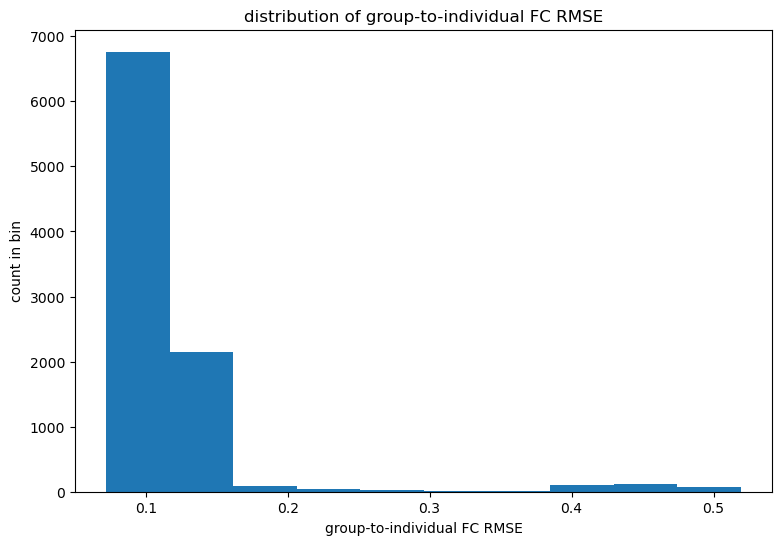

The distribution of group-to-individual FC RMSE has median 0.108 with 95% CI [0.0854, 0.414] and range [0.0723, 0.519].


In [78]:
name = 'group-to-individual FC RMSE'
make_histogram(name=name, values=fc_rmse_group_to_individual)
print_stats( name=name, values=fc_rmse_group_to_individual )

In [82]:
fc_correlation_group_to_individual_file = os.path.join(results_dir, f'fc_correlation_group_to_individual_training_parallel_10000_beta_sims_3_fitting_sims_20_steps_120000_learning_rate_1e-10.pt')
fc_correlation_group_to_individual = torch.load(fc_correlation_group_to_individual_file)
print( 'fc_correlation_group_to_individual size', fc_correlation_group_to_individual.size() )

fc_correlation_group_to_individual size torch.Size([9366])


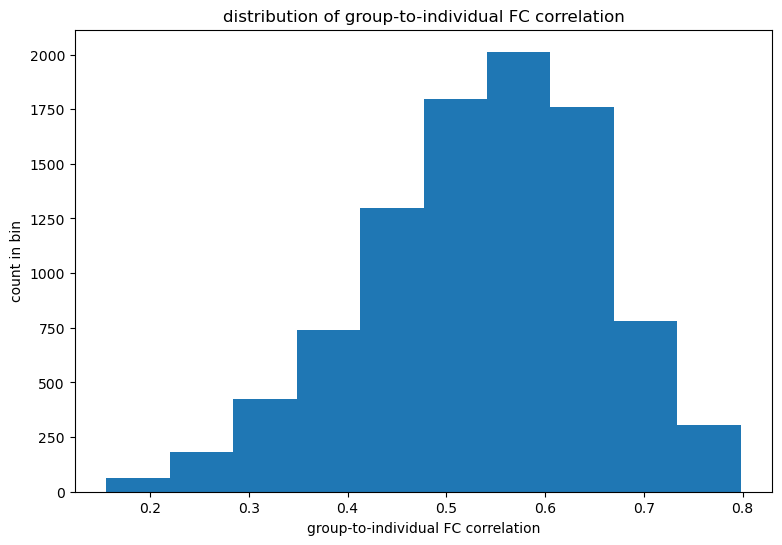

The distribution of group-to-individual FC correlation has median 0.548 with 95% CI [0.282, 0.748] and range [0.156, 0.798].


In [83]:
name = 'group-to-individual FC correlation'
make_histogram(name=name, values=fc_correlation_group_to_individual)
print_stats( name=name, values=fc_correlation_group_to_individual )

In [45]:
fc_rmse_individual_file = os.path.join(results_dir, f'fc_rmse_individual_training_parallel_25_beta_sims_8_fitting_sims_30_steps_120000_learning_rate_0.01.pt')
fc_rmse_individual = torch.load(fc_rmse_individual_file)
print( 'fc_rmse_individual size', fc_rmse_individual.size() )

fc_rmse_individual size torch.Size([16725])


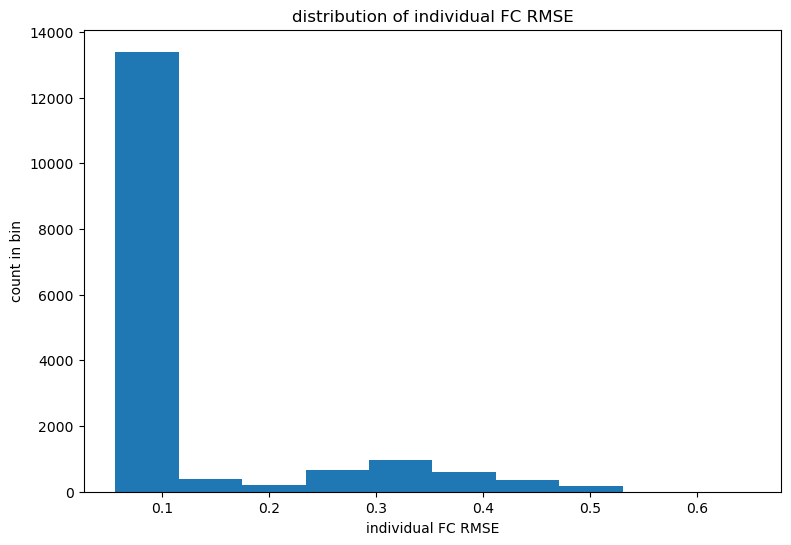

The distribution of individual FC RMSE has median 0.0893 with 95% CI [0.0687, 0.424] and range [0.0566, 0.649].


In [46]:
name = 'individual FC RMSE'
make_histogram(name=name, values=fc_rmse_individual)
print_stats( name=name, values=fc_rmse_individual )

In [47]:
fc_correlation_individual_file = os.path.join(results_dir, f'fc_correlation_individual_training_parallel_25_beta_sims_8_fitting_sims_30_steps_120000_learning_rate_0.01.pt')
fc_correlation_individual = torch.load(fc_correlation_individual_file)
print( 'fc_correlation_individual size', fc_correlation_individual.size() )

fc_correlation_individual size torch.Size([16725])


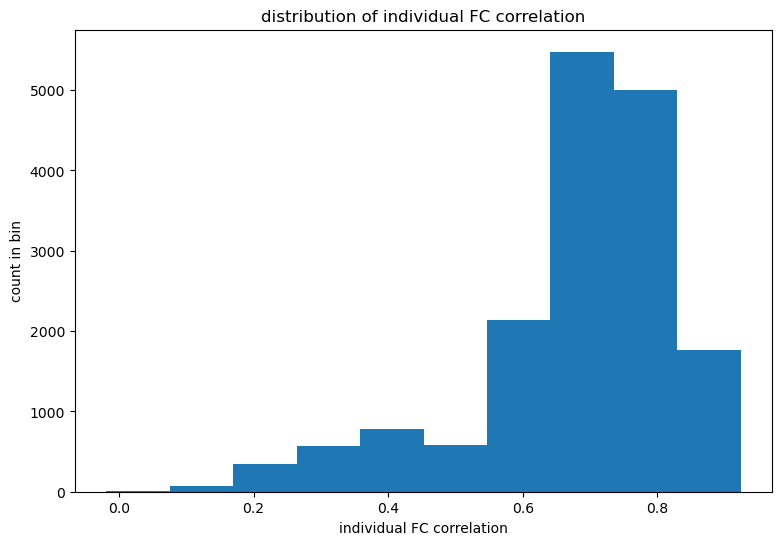

The distribution of individual FC correlation has median 0.708 with 95% CI [0.266, 0.872] and range [-0.0187, 0.924].


In [48]:
name = 'individual FC correlation'
make_histogram(name=name, values=fc_correlation_individual)
print_stats( name=name, values=fc_correlation_individual )

In [41]:
fc_rmse_group_file = os.path.join(results_dir, f'fc_rmse_group_training_parallel_10000_beta_sims_3_fitting_sims_40_steps_120000_learning_rate_0.1.pt')
fc_rmse_group = torch.load(fc_rmse_group_file)
print( 'fc_rmse_group size', fc_rmse_group.size() )

fc_rmse_group size torch.Size([10000])


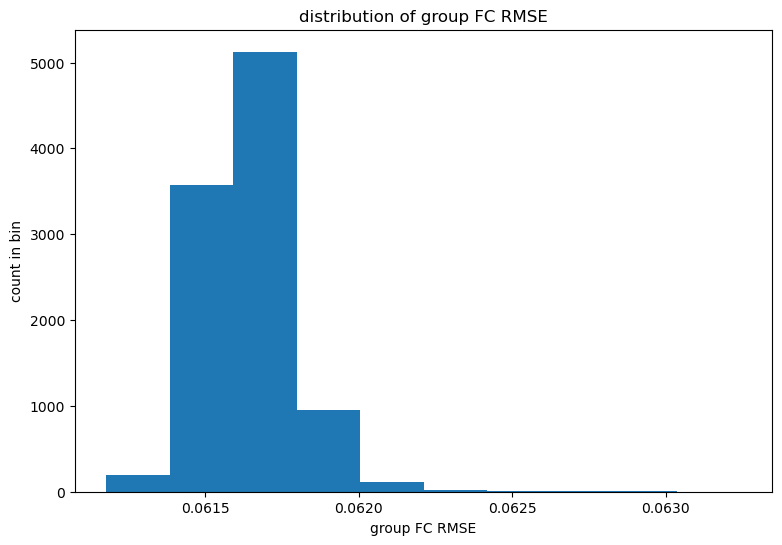

The distribution of group FC RMSE has median 0.0616 with 95% CI [0.0614, 0.062] and range [0.0612, 0.0632].


In [42]:
name = 'group FC RMSE'
make_histogram(name=name, values=fc_rmse_group)
print_stats(name=name, values=fc_rmse_group)

In [43]:
fc_correlation_group_file = os.path.join(results_dir, f'fc_correlation_group_training_parallel_10000_beta_sims_3_fitting_sims_40_steps_120000_learning_rate_0.1.pt')
fc_correlation_group = torch.load(fc_correlation_group_file)
print( 'fc_correlation_group size', fc_correlation_group.size() )

fc_correlation_group size torch.Size([10000])


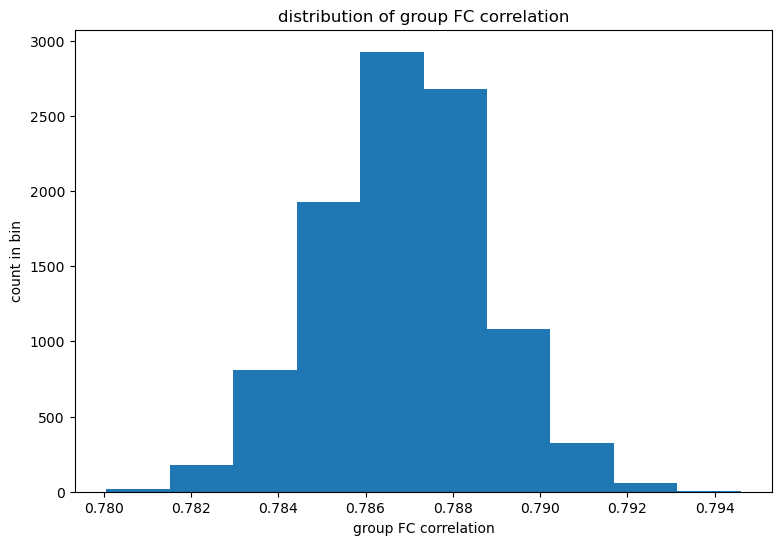

The distribution of group FC correlation has median 0.787 with 95% CI [0.783, 0.791] and range [0.78, 0.795].


In [44]:
name = 'group FC correlation'
make_histogram(name=name, values=fc_correlation_group)
print_stats(name=name, values=fc_correlation_group)

In [11]:
best_fc_rmse_index = torch.argmin(fc_rmse_group)
best_fc_rmse = fc_rmse_group[best_fc_rmse_index]
print(f'best RMSE is {best_fc_rmse.item():.3g} at index {best_fc_rmse_index}.')
best_fc_correlation_index = torch.argmin(fc_correlation_group)
best_fc_correlation = fc_correlation_group[best_fc_correlation_index]
print(f'best correlation is {best_fc_correlation.item():.3g} at index {best_fc_correlation_index}.')

best RMSE is 0.0757 at index 5191.
best correlation is 0.633 at index 3447.


In [101]:
# ising_model_group_training_epochs_50_batch_12000_lr_1e-07.pt
transition_prob_ising_params_file = os.path.join(results_dir, f'ising_model_group_training_epochs_20_batch_12000_lr_1e-07.pt')
transition_prob_ising_params = torch.load(transition_prob_ising_params_file)
print( 'transition_prob_ising_params size', transition_prob_ising_params.size() )
num_nodes = hcp.num_brain_areas

transition_prob_ising_params size torch.Size([64980])


In [102]:
num_nans = torch.count_nonzero( torch.isnan(transition_prob_ising_params) )
num_params = transition_prob_ising_params.numel()
print(f'{num_nans} NaN values out of {num_params}')

64980 NaN values out of 64980


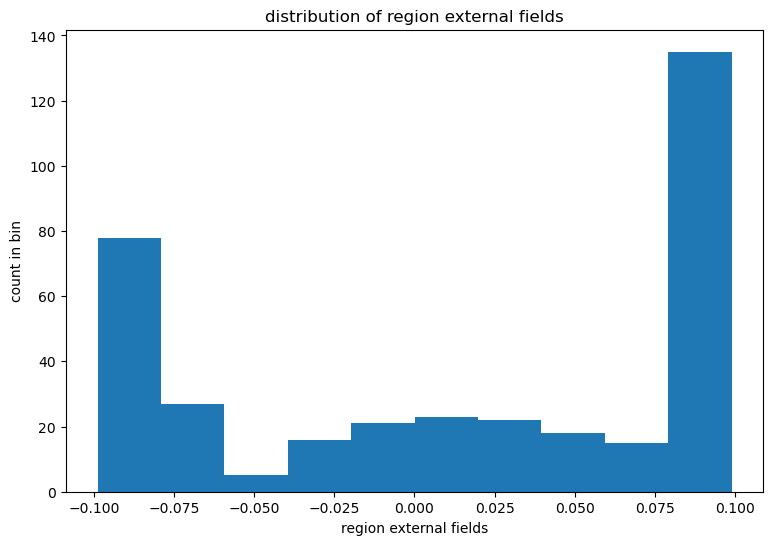

The distribution of region external fields has median 0.0289 with 95% CI [-0.0983, 0.0984] and range [-0.0988, 0.0989].


In [99]:
transition_prob_h = transition_prob_ising_params[:num_nodes]
name = 'region external fields'
make_histogram(name=name, values=transition_prob_h)
print_stats(name=name, values=transition_prob_h)

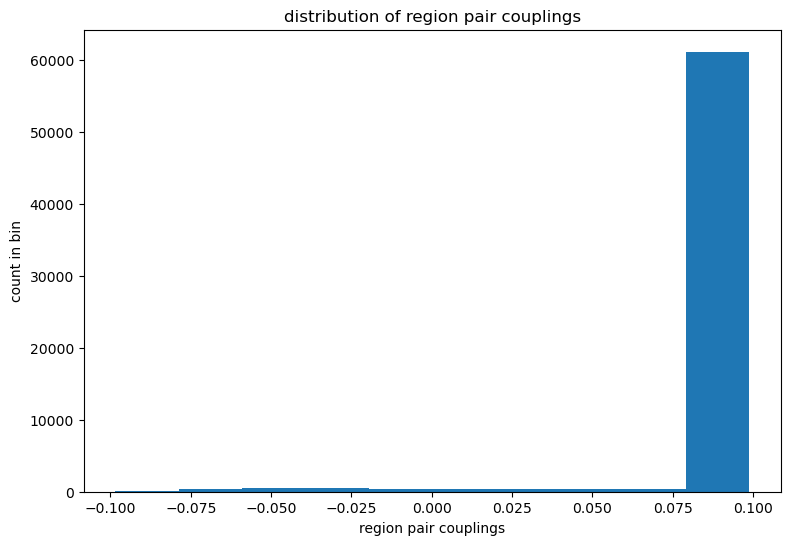

The distribution of region pair couplings has median 0.0947 with 95% CI [-0.0139, 0.0985] and range [-0.0985, 0.0989].


In [100]:
transition_prob_J = transition_prob_ising_params[num_nodes:]
name = 'region pair couplings'
make_histogram(name=name, values=transition_prob_J)
print_stats(name=name, values=transition_prob_J)

In [106]:
ising_model_group_training_file = os.path.join(results_dir, f'ising_model_group_training_parallel_10000_beta_sims_3_fitting_sims_20_steps_120000_learning_rate_0.1.pt')
ising_model_group_training = torch.load(ising_model_group_training_file)
print( 'transition_prob_ising_params size', ising_model_group_training )

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.83 GiB (GPU 0; 8.00 GiB total capacity; 1.77 GiB already allocated; 3.49 GiB free; 3.10 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [40]:
fc_group_training_file = os.path.join(results_dir, f'fc_group_training.pt')
fc_group_training = torch.load(fc_group_training_file)
print( 'fc_group_training size', fc_group_training.size() )

fc_group_training size torch.Size([1, 64620])
